In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score

In [2]:
import shap
shap.initjs()

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
df = pd.read_pickle('../../data/interim/final_last_view.pickle')

In [6]:
def label_encode_categories(df):
    '''
    label encodes gender and id, removing previous created one hot encoding    
    
    '''
    le = LabelEncoder()
    df.id = le.fit_transform(df.id)
    le.fit_transform(df.id)
    df['gender'] = df[['F', 'M', 'O']].idxmax(1)
    df.gender = le.fit_transform(df.gender)
    df = df.drop(['F', 'M', 'O'], axis=1)
    return df

In [7]:
df = label_encode_categories(df)

In [8]:
def train_test_by_time(df):
    '''
    Splits dataframe into 75% train and 25% test by signed_up date.
    Test data is taken from the 25% newest offers, this comprises a different customer base to the train set and requries prediction of the future.    
    '''
        
    test_data = df[df.signed_up >= df.signed_up.quantile(q=.75)]
    train_data = df[df.signed_up < df.signed_up.quantile(q=.75)]
    
    X_train = train_data.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining to complete', 'viewed_in_valid', 'offer_spend'], axis=1)
    y_train = X_train.complete
    X_train = X_train.drop('complete', axis=1)

    X_test = test_data.drop(['person', 'received_spend', 'viewed_spend', 'viewed_days_left', 'remaining to complete', 'viewed_in_valid', 'offer_spend'], axis=1)
    y_test = X_test.complete
    X_test = X_test.drop('complete', axis=1)
    
    
    print('X_train', X_train.shape, round(X_train.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('X_test', X_test.shape, round(X_test.shape[0] / (X_train.shape[0]+X_test.shape[0]), 4))
    print('y_train', y_train.shape)
    print('y_test', y_test.shape)
    
    
    
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = train_test_by_time(df)

X_train (57122, 53) 0.7489
X_test (19155, 53) 0.2511
y_train (57122,)
y_test (19155,)


In [11]:
cat_features = [3, 52]
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

In [12]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    early_stopping_rounds=40,
    scale_pos_weight=30,
    max_depth=8,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [13]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

array([[11395,  7149],
       [  152,   459]], dtype=int64)

In [14]:
np.array(model.get_feature_importance(prettified=True))

array([['difficulty', 10.085819962092497],
       ['income', 9.278213441084734],
       ['last_amount', 9.194475528685818],
       ['age', 6.226583110080498],
       ['signed_up', 5.658344815869393],
       ['id', 5.371631924441155],
       ['t_365', 4.372827475572178],
       ['t_2000', 4.365295657646319],
       ['duration', 3.816982397383076],
       ['reward', 3.688319935482249],
       ['last_transaction', 2.76500533471113],
       ['mobile', 2.493958072696786],
       ['t_2000c', 2.07877566361851],
       ['last_transaction_days', 1.753555930586352],
       ['t_365c', 1.6534344091236668],
       ['last_view_date', 1.554955276155032],
       ['time', 1.529368355022887],
       ['weekday', 1.5069381847235812],
       ['hist_difficulty_possible', 1.4621432479080516],
       ['date', 1.4599487672206752],
       ['day', 1.3358253348154556],
       ['t_84', 1.286506876237601],
       ['year', 1.24465083594466],
       ['month', 1.2259537209631575],
       ['t_84c', 1.2039863771637487],

In [15]:
np.array(model.get_feature_importance(
    train_pool,
    'LossFunctionChange',
    prettified=True
))

array([['last_amount', 0.015617958549041189],
       ['income', 0.009349011731586698],
       ['difficulty', 0.009246680913754579],
       ['signed_up', 0.006835948075973763],
       ['id', 0.006410638033759186],
       ['t_2000', 0.004803608919480062],
       ['t_365', 0.0042277236029409915],
       ['age', 0.004201283771681774],
       ['reward', 0.002691498865679376],
       ['duration', 0.0023973645817757516],
       ['last_transaction', 0.0014854017249698592],
       ['last_view_date', 0.0013369698362888927],
       ['mobile', 0.0012893510750466852],
       ['t_2000c', 0.0012395993948184914],
       ['date', 0.0010504090464214522],
       ['time', 0.000986510116169681],
       ['t_84', 0.0009578325241998975],
       ['t_365c', 0.0009273662178949649],
       ['weekday', 0.0009230974815822024],
       ['hist_difficulty_possible', 0.0009066062386137164],
       ['last_transaction_days', 0.0008775678788104924],
       ['year', 0.0008555047503722712],
       ['day', 0.00083513057964373

In [16]:
shap_values = model.get_feature_importance(test_pool, 'ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

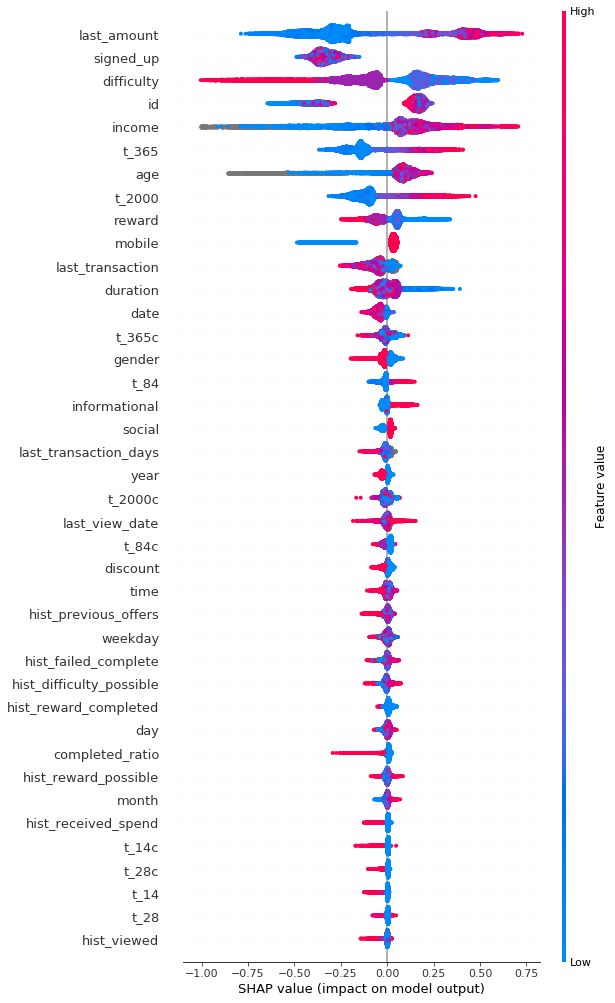

In [17]:
shap.summary_plot(shap_values, X_test, max_display=40)

In [18]:
shap_values = model.get_feature_importance(train_pool, 'ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

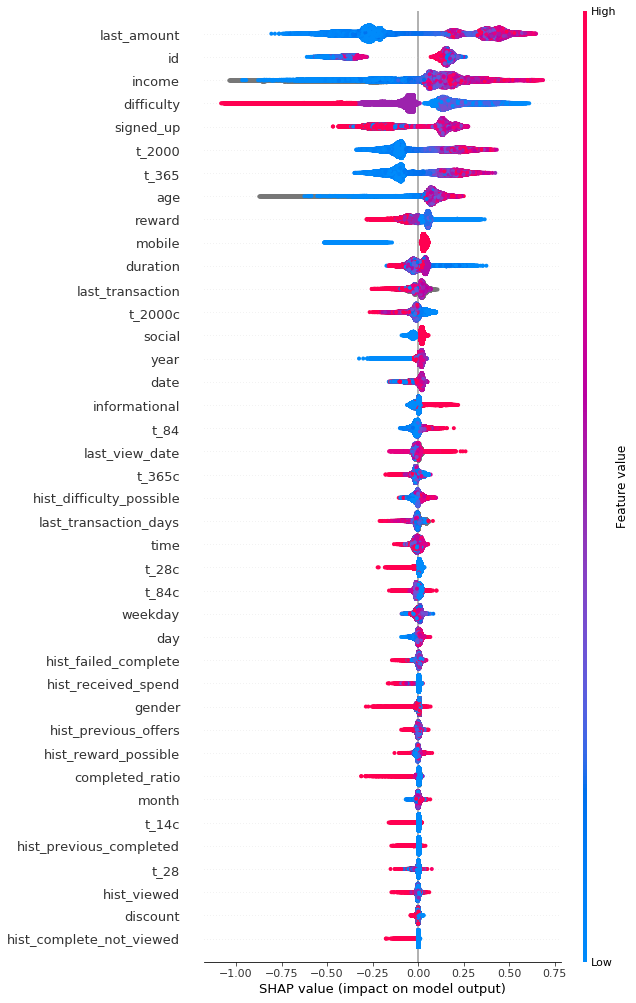

In [19]:
shap.summary_plot(shap_values, X_train, max_display=40)

### Trying again

In [18]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    early_stopping_rounds=40,
    scale_pos_weight=30,
    max_depth=10,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [19]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

array([[11553,  6991],
       [  161,   450]], dtype=int64)

In [20]:
np.array(model.get_feature_importance(prettified=True))

array([['income', 8.729290354657156],
       ['difficulty', 6.865623279965558],
       ['last_amount', 6.418996282452097],
       ['id', 5.771084881997412],
       ['age', 5.7484609026925035],
       ['signed_up', 5.350762135321047],
       ['t_365', 4.300522546265143],
       ['reward', 3.7773992210666605],
       ['duration', 3.5447916337092082],
       ['t_2000', 3.388182619453727],
       ['day', 2.4587839653203454],
       ['weekday', 2.4353151961839723],
       ['last_transaction', 2.426418266350067],
       ['gender', 2.199015639434668],
       ['mobile', 2.103923950788043],
       ['date', 2.0989555535263476],
       ['month', 2.016592329042558],
       ['t_2000c', 1.9109194712440027],
       ['last_view_date', 1.8710028986549267],
       ['time', 1.7802336312067084],
       ['hist_reward_completed', 1.7758586130759435],
       ['last_transaction_days', 1.69190672841234],
       ['t_84', 1.6351530979962556],
       ['hist_reward_possible', 1.5944243079095601],
       ['hist_dif

In [21]:
np.array(model.get_feature_importance(test_pool,
    'LossFunctionChange',
    prettified=True
))

array([['last_amount', 0.017560169646782864],
       ['income', 0.007401026456341109],
       ['t_2000', 0.005613255769206016],
       ['t_365', 0.00529361392333938],
       ['difficulty', 0.005162819644059513],
       ['signed_up', 0.004588293844506097],
       ['age', 0.003356268009032659],
       ['id', 0.0032626398832993897],
       ['reward', 0.0011499218657249344],
       ['duration', 0.0010448510089072771],
       ['mobile', 0.0005937199702664708],
       ['t_84c', 0.00048226901132897293],
       ['last_transaction', 0.0003770560903439968],
       ['informational', 0.0003621249893248635],
       ['discount', 0.0003305420331978226],
       ['social', 0.0002199558602929974],
       ['date', 0.00019709602922035607],
       ['gender', 0.00018890021968798187],
       ['t_84', 7.99982441581637e-05],
       ['hist_difficulty_possible', 3.504206967841483e-05],
       ['t_365c', 3.0509553367030762e-05],
       ['t_28c', 2.823447146182989e-05],
       ['hist_viewed_spend', 6.1889115356983

In [22]:
shap_values = model.get_feature_importance(test_pool, 'ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

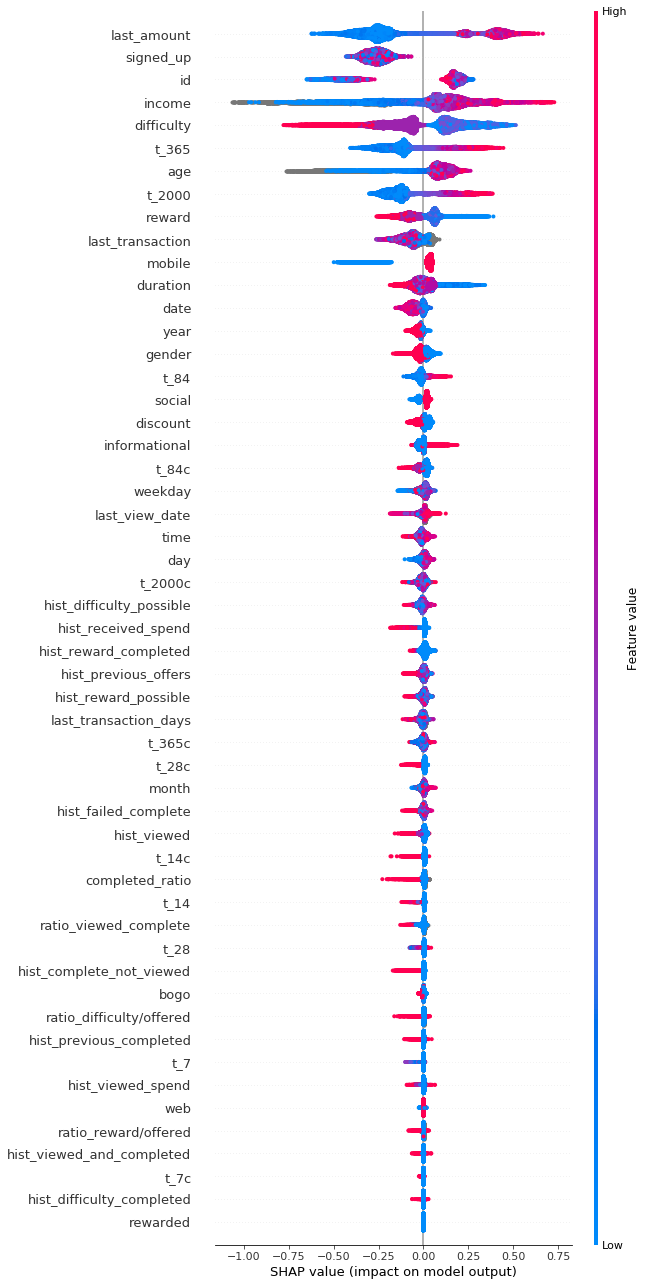

In [23]:
shap.summary_plot(shap_values, X_test, max_display=100)

### Try again 2

In [24]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=32,
    max_depth=10,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

### try with less depth

In [ ]:
model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=32,
    max_depth=6,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# try less weight

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=6,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# try depth 7 

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=7,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# try depth 8

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=8,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# try depth 5

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=5,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

In [ ]:
np.array(model.get_feature_importance(prettified=True))

In [ ]:
np.array(model.get_feature_importance(test_pool,
    'LossFunctionChange',
    prettified=True
))

In [ ]:
np.array(model.get_feature_importance(train_pool,
    'LossFunctionChange',
    prettified=True
))

In [ ]:
shap_values = model.get_feature_importance(test_pool, 'ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=100)

In [ ]:
# try depth 4

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=4,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# depth 5 seems to be best, increase weight to 32

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=32,
    max_depth=5,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# Using the max depth 5 and weight 30

In [ ]:
# removing bottom 20 features - how does this effect?

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=5,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

In [ ]:
importance = np.array(model.get_feature_importance(prettified=True))

In [ ]:
importance_remove = np.array(model.get_feature_importance(train_pool,
    'LossFunctionChange',
    prettified=True
))

In [ ]:
importance[-20:]

In [ ]:
importance_remove[-20:][:,0]

In [ ]:
importance[-20:][:,0]

In [ ]:
# taking bottom 20 features of importance and importance_remove and selecting only those in both
to_remove = pd.Series(importance_remove[-20:][:,0])[pd.Series(importance_remove[-20:][:,0]).isin(importance[-20:][:,0])]

In [ ]:
to_remove.values

In [ ]:
shap_values = model.get_feature_importance(test_pool, 'ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=100)

In [ ]:
df.drop(to_remove.values, axis=1, inplace=True)

In [ ]:
df

In [ ]:
X_train, X_test, y_train, y_test = train_test_by_time(df)

In [ ]:
cat_features = [3, 34]

In [ ]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=5,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

### with 8 max depth

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=8,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=28,
    max_depth=8,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

In [ ]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=28,
    max_depth=10,    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

In [ ]:
model1 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=5,
    train_dir='max_depth_5',
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [ ]:
model2 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    train_dir='max_depth_6',    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [ ]:
model3 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    train_dir='max_depth_7',   
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [ ]:
model4 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    train_dir='max_depth_8',
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [ ]:
model5 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    train_dir='max_depth_9', 
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [ ]:
model6 = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    train_dir='max_depth_10',    
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [ ]:
'''
model1.fit(train_pool, eval_set=test_pool, verbose=20)
model2.fit(train_pool, eval_set=test_pool, verbose=20)
model3.fit(train_pool, eval_set=test_pool, verbose=20)
model4.fit(train_pool, eval_set=test_pool, verbose=20)
model5.fit(train_pool, eval_set=test_pool, verbose=20)
model6.fit(train_pool, eval_set=test_pool, verbose=20)
'''

In [ ]:
'''
from catboost import MetricVisualizer
MetricVisualizer(['max_depth_5', 'max_depth_6', 'max_depth_7', 'max_depth_8', 'max_depth_9', 'max_depth_10', 'max_depth_11']).start()
'''

In [51]:
model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.01,
    early_stopping_rounds=50,
    scale_pos_weight=30,
    max_depth=5,
    train_dir='max_depth_5',
    custom_loss=['AUC', 'Accuracy', 'F1', 'Recall', 'Precision']
)

In [52]:
model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [53]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

array([[11564,  6980],
       [  155,   456]], dtype=int64)

In [55]:
import timeit
start_time = timeit.default_timer()


model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True
);

# code you want to evaluate
elapsed = timeit.default_timer() - start_time

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
elapsed

85.61242230000062

In [56]:
import timeit
start_time = timeit.default_timer()


model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=True,
    task_type='GPU'
);

# code you want to evaluate
elapsed = timeit.default_timer() - start_time

TypeError: fit() got an unexpected keyword argument 'task_type'

In [ ]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

# Trying cross validation

In [28]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 3000,
    'custom_loss': ['AUC', 'Logloss', 'F1', 'Recall', 'Precision'],
    'learning_rate': 0.01,
    'max_depth': 5
}

cv_data = cv(
    params = params,
    early_stopping_rounds=50,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [ ]:
cv_data.head(10)

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

In [29]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

curve = get_roc_curve(model, test_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

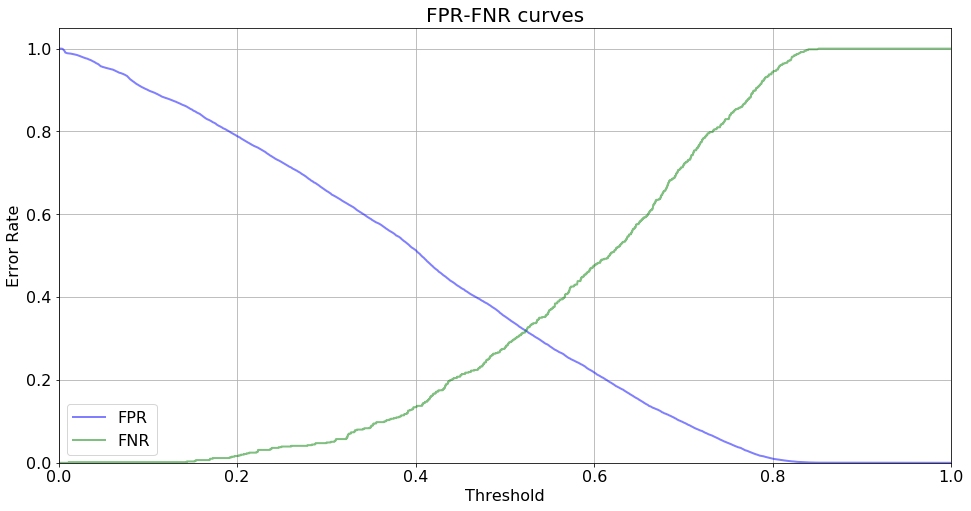

In [30]:
plt.figure(figsize=(16, 8))
style = {'alpha':0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16);

In [31]:
from catboost.utils import select_threshold

print(select_threshold(model, test_pool, FNR=0.01))
print(select_threshold(model, test_pool, FPR=0.01))

0.17277491095492023
0.800102844297589


In [32]:
pred = model.predict(X_test)

In [33]:
pred

array([0., 1., 1., ..., 0., 0., 0.])

In [34]:
new_pred = (model.predict_proba(X_test))
new_pred

array([[0.52435457, 0.47564543],
       [0.37559446, 0.62440554],
       [0.30023757, 0.69976243],
       ...,
       [0.69157081, 0.30842919],
       [0.76013464, 0.23986536],
       [0.65953786, 0.34046214]])

In [35]:
new_pred = (model.predict_proba(X_test) < 0.58)[:,0]*1

In [36]:
(model.predict_proba(X_test) > 0.5)[:,1].sum()

6995

In [37]:
pred = model.predict(X_test)
confusion_matrix(y_test, pred)

array([[11990,  6554],
       [  170,   441]], dtype=int64)

In [38]:
pred = model.predict(X_test)
confusion_matrix(y_test, new_pred)

array([[9788, 8756],
       [ 102,  509]], dtype=int64)

In [41]:
confusion_matrix(y_test, new_pred).sum()

19155

In [44]:
X_train

time   age    income  id  rewarded  difficulty  reward  duration  \
0         0  75.0  100000.0   6       0.0         5.0     5.0       7.0   
1       168  75.0  100000.0   9       0.0         0.0     0.0       3.0   
2       408  75.0  100000.0   1       0.0        10.0    10.0       7.0   
3       504  75.0  100000.0   7       0.0         5.0     5.0       5.0   
4         0   NaN       NaN   0       0.0        20.0     5.0      10.0   
...     ...   ...       ...  ..       ...         ...     ...       ...   
76272   504  47.0   94000.0   8       0.0         0.0     0.0       4.0   
76273   576  47.0   94000.0   2       0.0        10.0    10.0       5.0   
76274   576   NaN       NaN   3       0.0        10.0     2.0      10.0   
76275   576   NaN       NaN   2       0.0        10.0    10.0       5.0   
76276   576  58.0   78000.0   2       0.0        10.0    10.0       5.0   

       mobile  web  social  bogo  discount  informational  signed_up  date  \
0         1.0  1.0     0.0   1.0       0.0            0.0       -443  -443   
1         1.0  0.0     1.0   0.0       0.0            1.0       -443  -275   
2         1.0  0.0     1.0   1.0       0.0            0.0       -443   -35   
3         1.0  1.0     1.0   1.0       0.0            0.0       -443    61   
4         0.0  1.0     0.0   0.0       1.0            0.0       -356  -356   
...       ...  ...     ...   ...       ...            ...        ...   ...   
76272     1.0  1.0     0.0   0.0       0.0            1.0       -286   218   
76273     1.0  1.0     1.0   1.0       0.0            0.0       -286   290   
76274     1.0  1.0     1.0   0.0       1.0            0.0       -235   341   
76275     1.0  1.0     1.0   1.0       0.0            0.0       -303   273   
76276     1.0  1.0     1.0   1.0       0.0            0.0       -644   -68   

       weekday  month  year  day  last_transaction  last_transaction_days  \
0            1      5  2017    9               NaN                    NaN   
1            1     10  2017   24            -299.0                   24.0   
2            3      6  2018   21             -65.0                   30.0   
3            1      9  2018   25             -65.0                  126.0   
4            4      8  2017    4               NaN                    NaN   
...        ...    ...   ...  ...               ...                    ...   
76272        4      3  2019    1               NaN                    NaN   
76273        6      5  2019   12               NaN                    NaN   
76274        1      7  2019    2             281.0                   60.0   
76275        3      4  2019   25               NaN                    NaN   
76276        5      5  2018   19               NaN                    NaN   

       last_amount  t_7  t_14   t_28   t_84   t_365  t_2000  t_7c  t_14c  \
0             0.00  0.0   0.0   0.00   0.00    0.00    0.00     0      0   
1            17.78  0.0   0.0  17.78  37.67   37.67   37.67     0      0   
2            23.93  0.0   0.0   0.00  23.93  110.99  110.99     0      0   
3            23.93  0.0   0.0   0.00   0.00   91.10  110.99     0      0   
4             0.00  0.0   0.0   0.00   0.00    0.00    0.00     0      0   
...            ...  ...   ...    ...    ...     ...     ...   ...    ...   
76272         0.00  0.0   0.0   0.00   0.00    0.00    0.00     0      0   
76273         0.00  0.0   0.0   0.00   0.00    0.00    0.00     0      0   
76274         2.57  0.0   0.0   0.00   2.57    2.57    2.57     0      0   
76275         0.00  0.0   0.0   0.00   0.00    0.00    0.00     0      0   
76276         0.00  0.0   0.0   0.00   0.00    0.00    0.00     0      0   

       t_28c  t_84c  t_365c  t_2000c  hist_reward_completed  \
0          0      0       0        0                    0.0   
1          1      2       2        2                    0.0   
2          0      1       5        5                    0.0   
3          0      0       4        5                    0.0   
4          0    